In [1]:
import pandas as pd
import os
from IPython.display import display, Markdown
from lightgbm import LGBMClassifier


from golemai.dataset.custom_column_selectors import JensenShannonSelector, ProportionAggSelector
from golemai.ml.sklearn_auto_trainer import SklearnAutoTrainer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone


In [2]:
trainer = SklearnAutoTrainer(
    project_name="hallu_sklearn",
)

In [11]:
EXP_NAME_CONTEXT = 'window_step_1__on_context__all__agg_weighted_llama2'

In [9]:
os.getcwd()

'c:\\Users\\Piotr.Matys\\Python_Projects\\hallu_project\\Research\\notebooks'

In [13]:
df = None

for f_ in os.listdir(os.path.join("..", "..", EXP_NAME_CONTEXT)):
        
    if f_.startswith('attension'):

        if df is None:
            df = pd.read_parquet(os.path.join("..", "..", EXP_NAME_CONTEXT, f_))
        else:
            df = pd.concat((df, pd.read_parquet(os.path.join("..", "..", EXP_NAME_CONTEXT, f_))))

df = df.dropna()

In [16]:
df['label'].value_counts()

label
0    361037
1     87986
Name: count, dtype: int64

In [25]:
df

,layer_0_head_0,layer_0_head_1,layer_0_head_2,layer_0_head_3,layer_0_head_4,layer_0_head_5,layer_0_head_6,layer_0_head_7,layer_0_head_8,layer_0_head_9,...,layer_31_head_25,layer_31_head_26,layer_31_head_27,layer_31_head_28,layer_31_head_29,layer_31_head_30,layer_31_head_31,context_perc,label,dataset
0,0.828125,0.912598,0.917480,0.583008,0.876953,0.916992,0.899902,0.934082,0.845215,0.932129,...,0.211670,0.203979,0.064697,0.458740,0.119629,0.216431,0.035675,0.9217,0,nq
1,0.859375,0.914551,0.915527,0.573242,0.875000,0.919434,0.891113,0.933105,0.879883,0.931641,...,0.222290,0.207520,0.072449,0.449463,0.119263,0.237061,0.039856,0.9212,0,nq
2,0.856934,0.907227,0.910645,0.522461,0.860840,0.913574,0.883301,0.925781,0.873047,0.918457,...,0.203735,0.125000,0.082214,0.405518,0.155884,0.310059,0.045807,0.9168,0,nq
3,0.850586,0.902832,0.910645,0.517090,0.858398,0.911621,0.892578,0.925781,0.865723,0.916992,...,0.174072,0.151733,0.073364,0.393799,0.167114,0.329590,0.043457,0.9163,0,nq
4,0.849609,0.900391,0.910156,0.514648,0.855957,0.912109,0.892090,0.925293,0.862793,0.917480,...,0.219116,0.165527,0.058197,0.433105,0.183594,0.410156,0.052216,0.9158,0,nq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41115,0.545898,0.603516,0.624023,0.186035,0.468506,0.618164,0.576660,0.704590,0.599609,0.585449,...,0.160767,0.142212,0.015961,0.238770,0.106201,0.208984,0.050476,0.6358,0,xsum
41116,0.507812,0.581543,0.623047,0.184570,0.468018,0.607910,0.570801,0.701660,0.527344,0.583008,...,0.145020,0.116760,0.015976,0.232056,0.099670,0.168823,0.042816,0.6348,0,xsum
41117,0.506836,0.579102,0.620117,0.179810,0.463135,0.607422,0.568848,0.698730,0.537109,0.576660,...,0.111450,0.095337,0.016205,0.241943,0.090332,0.137451,0.031586,0.6338,0,xsum
41118,0.588379,0.705078,0.708496,0.402344,0.660645,0.672852,0.708496,0.785156,0.612793,0.707031,...,0.247559,0.185547,0.044769,0.304199,0.111206,0.204102,0.073547,0.7130,0,xsum


In [19]:
N_LAYERS = 32
N_HEADS = 32

In [20]:

df.columns = [
    f'layer_{i}_head_{j}' for i in range(N_LAYERS) for j in range(N_HEADS)
] + [
    'context_perc', 'label', 'dataset', 'example_name'
]

In [22]:
df['label'].value_counts()

label
0    361037
1     87986
Name: count, dtype: int64

In [31]:
TOP_N_FEATURES = 50
SPLIT_VAL = True

In [23]:
lgbm_config = {
    'n_estimators': 250,
    'learning_rate': 0.001,
    'max_depth': 10,
    'num_leaves': 15,
    'random_state': 42,
    'n_jobs': -1,
    'silent': True,
    'verbose': -1,
    'class_weight': 'balanced'
}

log_reg_config = {
    'max_iter': 10000,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1
}

In [24]:
df = df.drop(columns=['example_name'])

In [32]:
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler


def random_undersample(X, y):
    return RandomUnderSampler(random_state=42).fit_resample(X, y)

models = {
    # 'lgbm_js': Pipeline(
    #     [
    #         ('selector', JensenShannonSelector(n_features=TOP_N_FEATURES)),
    #         ('sampler', FunctionSampler(func=random_undersample)),
    #         ('model', LGBMClassifier(
    #             **lgbm_config
    #         )),
    #     ]
    # ),
    # 'lgbm_pa': Pipeline(
    #     [
    #         ('selector', ProportionAggSelector(n_features=TOP_N_FEATURES)),
    #         ('sampler', FunctionSampler(func=random_undersample)),
    #         ('model', LGBMClassifier(
    #             **lgbm_config
    #         )),
    #     ]
    # ),
    # 'lgbm_all': Pipeline(
    #     [
    #         ('sampler', FunctionSampler(func=random_undersample)),
    #         ('model', LGBMClassifier(
    #             **lgbm_config
    #         )),
    #     ]
    # ),
    # 'lgbm_all_no_sampler': Pipeline(
    #     [
    #         ('model', LGBMClassifier(
    #             **lgbm_config
    #         )),
    #     ]
    # ),
    'logistic_reg_js': Pipeline(
        [
            ('selector', JensenShannonSelector(n_features=TOP_N_FEATURES)),
            ('sampler', FunctionSampler(func=random_undersample)),
            ('scaler', MinMaxScaler()),
            ('model', LogisticRegression(**log_reg_config)),
        ]
    ),
    # 'logistic_reg_pa': Pipeline(
    #     [
    #         ('selector', ProportionAggSelector(n_features=TOP_N_FEATURES)),
    #         ('sampler', FunctionSampler(func=random_undersample)),
    #         ('scaler', RobustScaler()),
    #         ('model', LogisticRegression(**log_reg_config)),
    #     ]
    # ),
    # 'logistic_reg_all': Pipeline(
    #     [
    #         ('sampler', FunctionSampler(func=random_undersample)),
    #         ('scaler', RobustScaler()),
    #         ('model', LogisticRegression(**log_reg_config)),
    #     ]
    # ),
    # 'logistic_reg_all_no_sampler': Pipeline(
    #     [
    #         ('scaler', MinMaxScaler()),
    #         ('model', LogisticRegression(**log_reg_config)),
    #     ]
    # ),

}

In [27]:
import wandb
from datetime import datetime

In [33]:
GROUP_NAME = f'weighted_mean_agg_lamma2_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'

In [29]:
span_type = 'context'

Training logistic_reg_js on span type context


c:\Users\Piotr.Matys\AppData\Local\anaconda3\envs\test-env\lib\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


c:\Users\Piotr.Matys\AppData\Local\anaconda3\envs\test-env\lib\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


test_auc_mean,▁
test_auc_std,▁
test_auprc_mean,▁
test_auprc_std,▁
train_auc_mean,▁
train_auc_std,▁
train_auprc_mean,▁
train_auprc_std,▁
validation_auc_mean,▁
validation_auc_std,▁
validation_auprc_mean,▁


KeyboardInterrupt: 

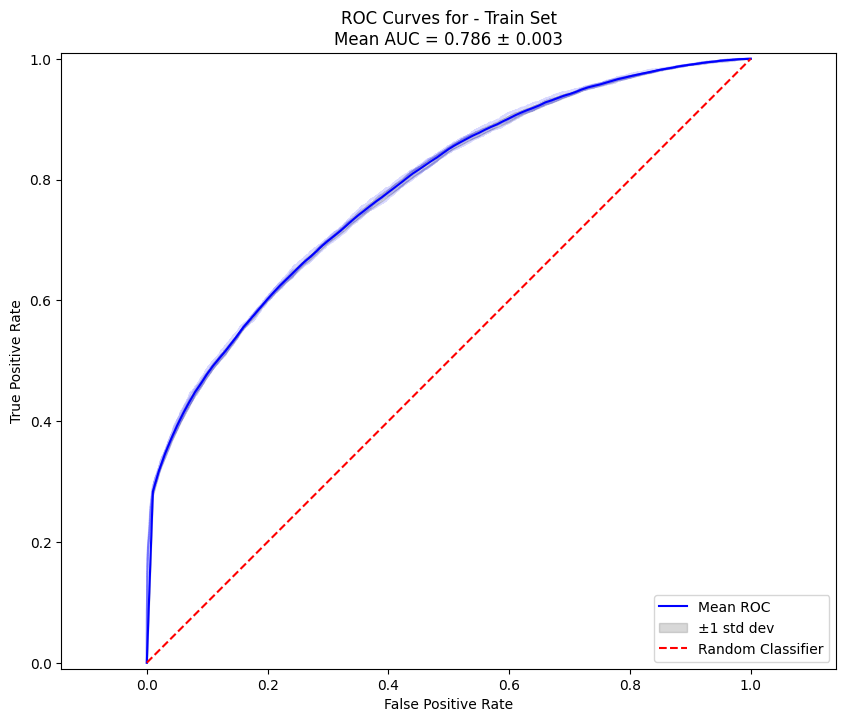

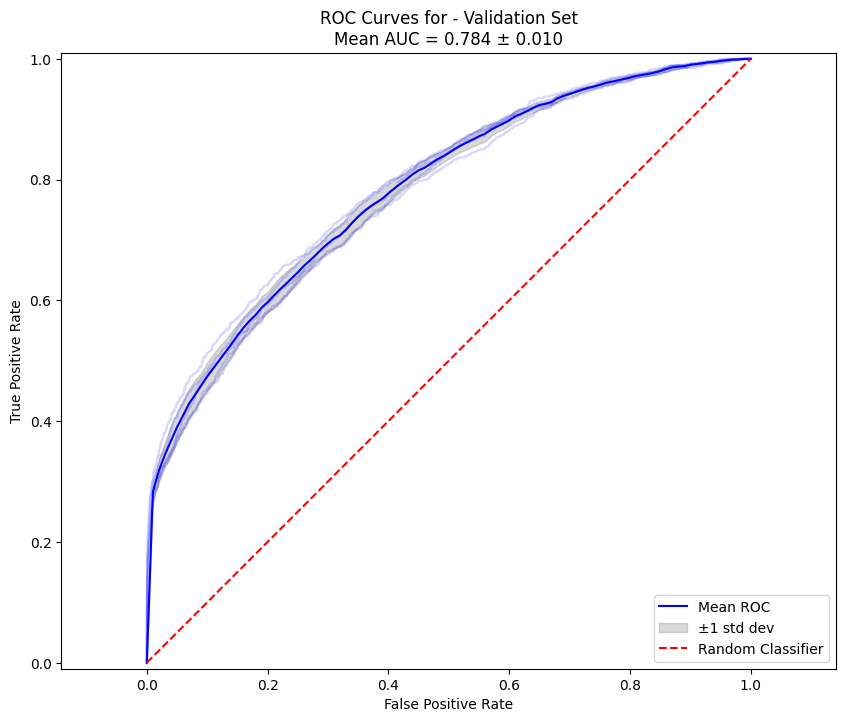

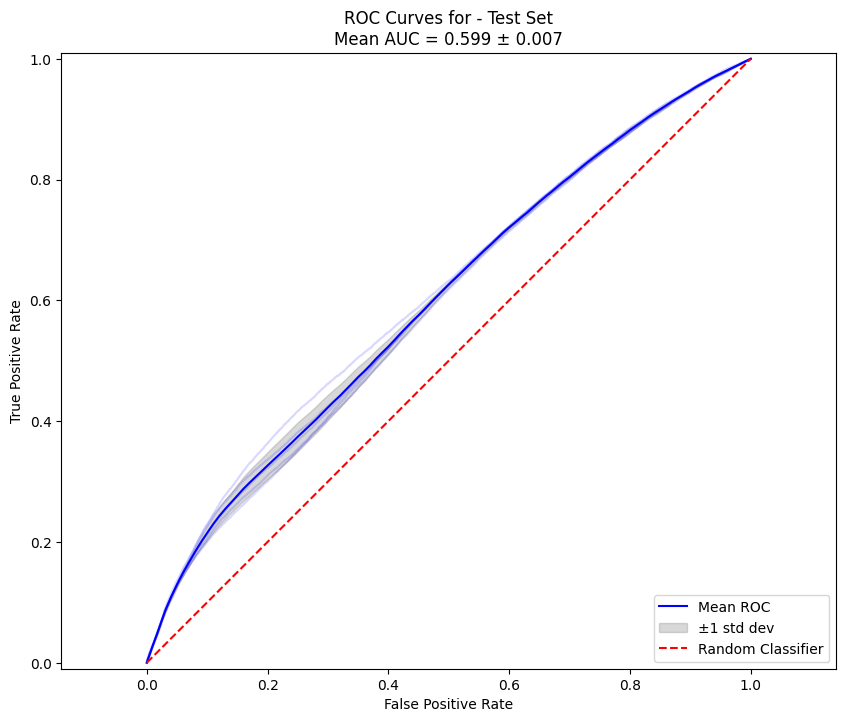

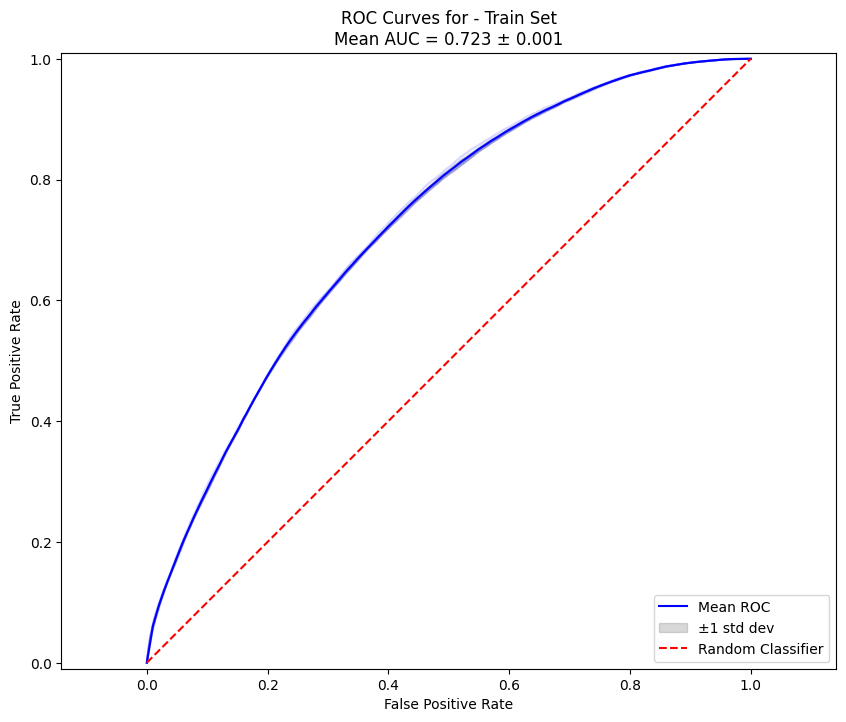

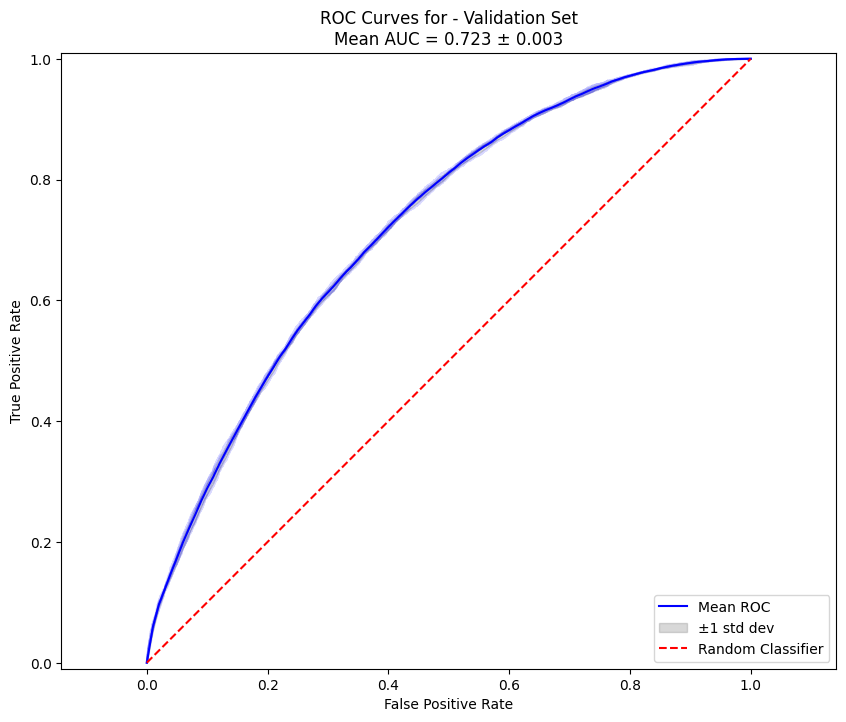

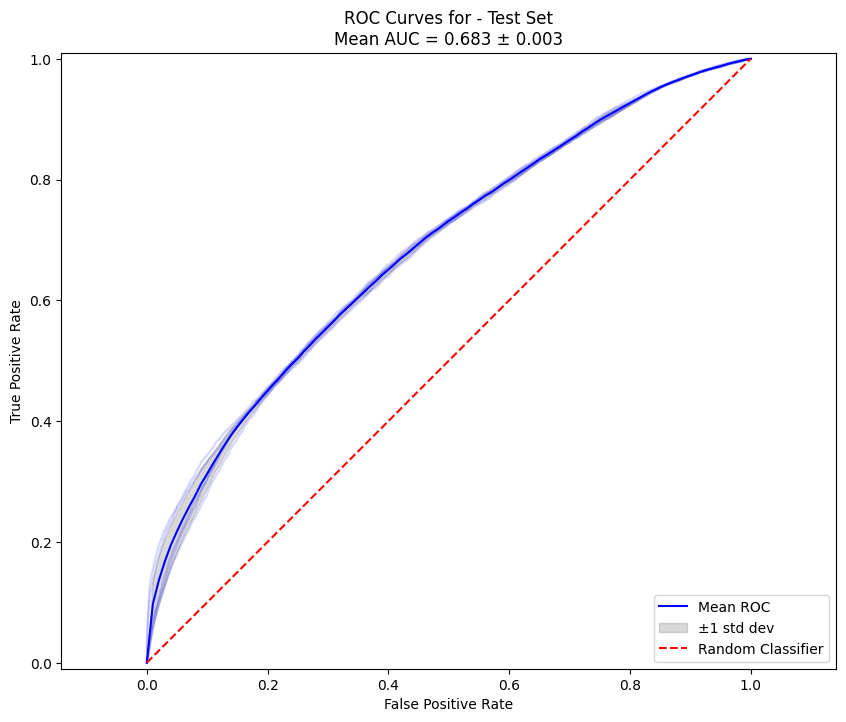

In [35]:
for model_name in models:

    print(f"Training {model_name} on span type {span_type}")

    pipepile = clone(models[model_name])
    
    trainer.evaluate(
        pipepile,
        df,
        group_name=GROUP_NAME,
        description=f"Test of {model_name} on span type {span_type}",
        span_type=span_type,
        base_model='lamma2'
    )

In [16]:
for span_type, filename in zip(['query', 'context'], [EXP_NAME_QUERY, EXP_NAME_CONTEXT]):

    df = None

    for f_ in os.listdir(os.path.join("..", "..", filename)):
        
        if f_.startswith('attension'):

            if df is None:
                df = pd.read_parquet(os.path.join("..", "..", filename, f_))
            else:
                df = pd.concat((df, pd.read_parquet(os.path.join("..", "..", filename, f_))))

    df = df.dropna()

    df.columns = [
        f'layer_{i}_head_{j}' for i in range(42) for j in range(16)
    ] + [
        'label', 'dataset'
    ]


    for model_name in models:

        print(f"Training {model_name} on span type {span_type}")

        pipepile = clone(models[model_name])
        
        trainer.evaluate(
            pipepile,
            df,
            group_name=GROUP_NAME,
            description=f"Test of {model_name} on span type {span_type}",
            span_type=span_type,
            base_model='gemma2'
        )

NameError: name 'EXP_NAME_QUERY' is not defined